# Import library required

In [1]:
import glob
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
pd.set_option('max_columns', None)


# File

In [2]:
class LookupFile:
    product_lookup = 'AdventureWorks_Products.csv'
    product_category_lookup = 'AdventureWorks_Product_Categories.csv'
    product_subcategory_lookup = 'AdventureWorks_Product_Subcategories.csv'
    customer = 'AdventureWorks_Customers.csv'
    calender = 'AdventureWorks_Calendar.csv'
    territory = 'AdventureWorks_Territories.csv'
    categorykey = 'AdventureWorks_Product_Categories.csv'
    subcategory = 'AdventureWorks_Product_Subcategories.csv'
    
    
    
class FactFile:
    _all_sales_file = glob.glob('*_Sales_*.csv')
    returns = 'AdventureWorks_Returns.csv'
    

# Lookup Table for Analysis

In [3]:
class LookUpTable:
    def __init__(self):
        self.AW_Product_Lookup = pd.read_csv(LookupFile.product_lookup)
        self.AW_Product_Lookup_preprocessed = self.__AW_product_lookup_preprocessing(self.AW_Product_Lookup)
        self.AW_Product_Category = pd.read_csv(LookupFile.product_category_lookup)
        self.AW_Product_Subcatrgory = pd.read_csv(LookupFile.product_subcategory_lookup)
        
        self.AW_Customer_Lookup = pd.read_csv(LookupFile.customer)
        self.AW_Customer_Lookup_preprocessed = self.__AW_customer_lookup_preprocessing(self.AW_Customer_Lookup)
        
        self.AW_Calender_Lookup = pd.read_csv(LookupFile.calender)
        self.AW_Calender_Lookup_preprocessed = self.__AW_calender_preprocessing(self.AW_Calender_Lookup)
        
        self.AW_Territories_Lookup = pd.read_csv(LookupFile.territory)
        self.AW_Territories_Lookup_indexed = pd.read_csv(LookupFile.territory, 
                                                         index_col= ['Continent', 'Country', 'Region'])\
                                                         .sort_index()
        
        self.AW_Product_Subcategory_Lookup = pd.read_csv(LookupFile.subcategory)
        
        
        
    def __AW_product_lookup_preprocessing(self, data):
        df = data.copy()
        
        df.drop(columns = ['ProductSize'], inplace = True)
        
        df['ProductPrice'] = round(df['ProductPrice'], 2)
        df['ProductCost'] = round(df['ProductCost'], 2)
        discount = 0.85
        df['DiscountedPrice'] = df['ProductPrice'] * discount
        
        df['SKUType'] = df['ProductSKU'].str.split('-').apply(lambda word: word[0] + '-' + word[1])
        df['ProductStyle'].replace('0', np.nan, inplace = True)
    
    
        return df
    
    def __AW_customer_lookup_preprocessing(self, data):
        df = data.copy()
        
        df['BirthDate'] = pd.to_datetime(df['BirthDate'], format= '%m/%d/%Y')
        df['BirthYear'] = df['BirthDate'].dt.year
        df['Age'] = pd.to_datetime('now').year - df['BirthYear']
        
        name_col = ['Prefix', 'FirstName', 'LastName']
        for col in name_col:
            df[col] = df[col].str.title()
            
        df['FullName'] = df.apply(lambda df: f"{df['Prefix']} {df['FirstName']} {df['LastName']}", axis=1)
        
        df['UserName']   = df['EmailAddress'].str.split('@').str.get(0)
        df['DomainName'] = df['EmailAddress'].str.split('[@|\.]').str.get(1)
        
        
        df['IncomeLevel'] = df['AnnualIncome']\
                                 .replace('[\D]', '', regex = True)\
                                 .astype('int')\
                                 .apply(self.income_level_converter)
        
        df['Parent'] = np.where(df['TotalChildren'] > 0 ,'Yes', 'No')
        
        
        return df
    
    def __AW_calender_preprocessing(self, data):
        df = data.copy()
        
        df['Date'] = pd.to_datetime(df['Date'], format = '%m/%d/%Y')
        
        df['DayName'] = df['Date'].dt.day_name()
        df['Day_of_Week'] = df['Date'].dt.dayofweek
        
        df['Start_of_Week'] = df[['Date', 'Day_of_Week']].apply(lambda df: df['Date'] - \
                                                                pd.tseries.offsets.DateOffset(days = df['Day_of_Week']), axis = 1)
        df['Start_of_Month'] = df['Date'].apply(lambda date: date.replace(day = 1))
        df['Start_of_Year']  = df['Date'].apply(lambda date: date.replace(month = 1, day = 1))
        
        df['MonthName'] = df['Date'].dt.month_name()
        df['Weekend'] = np.where(df['Day_of_Week'].isin([6,7]), 'Weekend', 'Weekday')
        
        df.rename(columns = {'Date':'ReturnDate'}, inplace = True)
        return df
    
    


    @staticmethod
    def income_level_converter(income):
        if income >= 1500000:
            return 'Very High'
        elif income >= 100000:
            return 'High'
        elif income > 50000:
            return 'Average'
        else:
            return 'Low'
        
            
lookup = LookUpTable()

# Fact Talbe
 **Sales** and **Return** 

In [4]:
class FactTable:
    def __init__(self):        
        self.AW_All_Sales = pd.concat([pd.read_csv(file) for file in FactFile._all_sales_file], axis = 0)
        self.AW_All_Sales_preprocessed = self.__Sales_preprocessing(self.AW_All_Sales)
        
        self.AW_Returns = pd.read_csv(FactFile.returns)
        self.AW_Returns_preprocessed = self.__AW_returns_preprocessing(self.AW_Returns)
    
        
    
    
    def __Sales_preprocessing(self, data):
        df = data.copy()
        
        df['QuantityType'] = df['OrderQuantity'].apply(self.order_quantity_classification)
        
        date_col = ['OrderDate', 'StockDate']
        for col in date_col:
            df[col] = pd.to_datetime(df[col], format = '%m/%d/%Y')
        
        df['Year'], df['Month'] = df['OrderDate'].dt.year, df['OrderDate'].dt.month
        
        df.rename(columns = {'TerritoryKey': 'SalesTerritoryKey'}, inplace = True)
        return df
    
    def __AW_returns_preprocessing(self, data):
        df = data.copy()
        df['ReturnDate'] = pd.to_datetime(df['ReturnDate'], format = '%m/%d/%Y')
        df.rename(columns = {'TerritoryKey': 'SalesTerritoryKey'}, inplace = True)
    
        return df
    
    @staticmethod
    def order_quantity_classification(element):
        if element == 1:
            return 'Single Item'
        if element > 1:
            return 'Multiple Item'
    
    
        

        
        
fact_table = FactTable()

# Merged File

In [14]:
class MergedReport:
    __lookup_table = LookUpTable()
    __fact_table = FactTable()
    def __init__(self):
        self.merged_sales = self._merged_sales_preprocessing(
                        pd.merge(
                            pd.merge(
                                pd.merge(
                                    pd.merge(self.__fact_table.AW_All_Sales_preprocessed,
                                     self.__lookup_table.AW_Customer_Lookup_preprocessed, how= 'inner')\
                                ,self.__lookup_table.AW_Product_Lookup_preprocessed, how = 'inner'),
                            self.__lookup_table.AW_Territories_Lookup, how = 'inner'),
                        self.__lookup_table.AW_Product_Subcategory_Lookup, how = 'inner'
                                                                     )
                                                            )
        
        self.merged_returns = pd.merge(
                                    pd.merge(
                                        pd.merge(self.__fact_table.AW_Returns_preprocessed, 
                                           self.__lookup_table.AW_Territories_Lookup, how = 'inner'),
                                            self.__lookup_table.AW_Product_Lookup_preprocessed, how = 'inner'),
                                             self.__lookup_table.AW_Calender_Lookup_preprocessed, how = 'inner')
    
    def _merged_sales_preprocessing(self, data):
        df = data.copy()
        df['Profit'] = df['ProductPrice'] - df['ProductCost']
        df['Revenue'] = round(df['Profit'] * df['OrderQuantity'],0)
        df['AnnualIncome'] = df['AnnualIncome'].str.replace('\D', '', regex = True).astype('int')
        
        return df
        

        

In [15]:
report = MergedReport()
report.merged_sales

,OrderDate,StockDate,OrderNumber,ProductKey,CustomerKey,SalesTerritoryKey,OrderLineItem,OrderQuantity,QuantityType,Year,Month,Prefix,FirstName,LastName,BirthDate,MaritalStatus,Gender,EmailAddress,AnnualIncome,TotalChildren,EducationLevel,Occupation,HomeOwner,BirthYear,Age,FullName,UserName,DomainName,IncomeLevel,Parent,ProductSubcategoryKey,ProductSKU,ProductName,ModelName,ProductDescription,ProductColor,ProductStyle,ProductCost,ProductPrice,DiscountedPrice,SKUType,Region,Country,Continent,SubcategoryName,ProductCategoryKey,Profit,Revenue
0,2016-01-01,2002-10-17,SO48797,385,14335,1,1,1,Single Item,2016,1,Ms.,Allison,Cox,1978-09-13,M,F,allison9@adventure-works.com,40000,0,High School,Skilled Manual,Y,1978,43,Ms. Allison Cox,allison9,adventure-works,Low,No,2,BK-R64Y-42,"Road-550-W Yellow, 42",Road-550-W,Same technology as all of our Road series bike...,Yellow,W,605.65,1000.44,850.374,BK-R64Y,Northwest,United States,North America,Road Bikes,1,394.79,395.0
1,2016-02-19,2002-11-29,SO49359,385,14343,1,1,1,Single Item,2016,2,Mr.,Xavier,Turner,1979-07-24,M,M,xavier37@adventure-works.com,40000,0,High School,Skilled Manual,Y,1979,42,Mr. Xavier Turner,xavier37,adventure-works,Low,No,2,BK-R64Y-42,"Road-550-W Yellow, 42",Road-550-W,Same technology as all of our Road series bike...,Yellow,W,605.65,1000.44,850.374,BK-R64Y,Northwest,United States,North America,Road Bikes,1,394.79,395.0
2,2016-04-11,2003-01-23,SO49999,385,14392,1,1,1,Single Item,2016,4,Mr.,Justin,Jackson,1947-08-24,M,M,justin31@adventure-works.com,70000,4,Bachelors,Management,Y,1947,74,Mr. Justin Jackson,justin31,adventure-works,Average,Yes,2,BK-R64Y-42,"Road-550-W Yellow, 42",Road-550-W,Same technology as all of our Road series bike...,Yellow,W,605.65,1000.44,850.374,BK-R64Y,Northwest,United States,North America,Road Bikes,1,394.79,395.0
3,2016-04-21,2003-02-18,SO50100,385,14385,1,1,1,Single Item,2016,4,Mrs.,Maria,Hall,1945-10-20,M,F,maria64@adventure-works.com,60000,4,Bachelors,Management,Y,1945,76,Mrs. Maria Hall,maria64,adventure-works,Average,Yes,2,BK-R64Y-42,"Road-550-W Yellow, 42",Road-550-W,Same technology as all of our Road series bike...,Yellow,W,605.65,1000.44,850.374,BK-R64Y,Northwest,United States,North America,Road Bikes,1,394.79,395.0
4,2016-04-22,2003-01-15,SO50104,385,14394,1,1,1,Single Item,2016,4,Mr.,Jacob,Rodriguez,1947-10-07,M,M,jacob16@adventure-works.com,70000,4,Bachelors,Management,Y,1947,74,Mr. Jacob Rodriguez,jacob16,adventure-works,Average,Yes,2,BK-R64Y-42,"Road-550-W Yellow, 42",Road-550-W,Same technology as all of our Road series bike...,Yellow,W,605.65,1000.44,850.374,BK-R64Y,Northwest,United States,North America,Road Bikes,1,394.79,395.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56041,2017-03-17,2003-12-09,SO66345,486,13530,10,3,1,Single Item,2017,3,Mrs.,Krystal,Chen,1943-09-25,M,F,krystal2@adventure-works.com,40000,1,Graduate Degree,Clerical,Y,1943,78,Mrs. Krystal Chen,krystal2,adventure-works,Low,Yes,27,ST-1401,All-Purpose Bike Stand,All-Purpose Bike Stand,Perfect all-purpose bike stand for working on ...,NaN,NaN,59.47,159.00,135.150,ST-1401,United Kingdom,United Kingdom,Europe,Bike Stands,4,99.53,100.0
56042,2017-05-25,2004-01-30,SO71313,486,16325,10,3,1,Single Item,2017,5,Mrs.,Emma,Williams,1913-09-10,S,F,emma1@adventure-works.com,30000,1,Partial College,Clerical,Y,1913,108,Mrs. Emma Williams,emma1,adventure-works,Low,Yes,27,ST-1401,All-Purpose Bike Stand,All-Purpose Bike Stand,Perfect all-purpose bike stand for working on ...,NaN,NaN,59.47,159.00,135.150,ST-1401,United Kingdom,United Kingdom,Europe,Bike Stands,4,99.53,100.0
56043,2017-04-28,2004-02-09,SO69201,486,25482,10,2,1,Single Item,2017,4,Mr.,Donald,Martinez,1962-03-20,S,M,donald19@adventure-works.com,30000,1,Partial College,Clerical,Y,1962,59,Mr. Donald Martinez,donald19,adventure-works,Low,Yes,27,ST-1401,All-Purpose Bike Stand,All-P

# Data Visualzation

#### Top 20 Best-Selling Products

<AxesSubplot:ylabel='ProductKey,ProductName'>

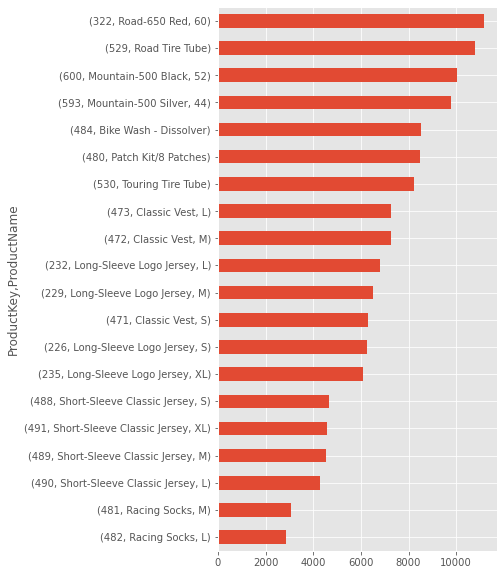

In [7]:
report.merged_sales.groupby(['ProductKey','ProductName'])\
        .sum()['Revenue'].sort_values(ascending = True).head(20).plot(kind = 'barh', figsize = (5,10))

#### Revenue Groupy by Product Category

<AxesSubplot:ylabel='SubcategoryName'>

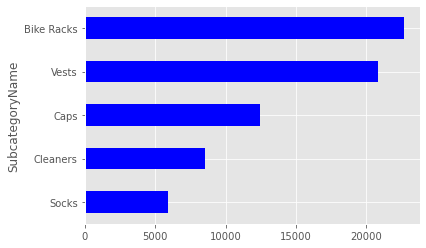

In [8]:
report.merged_sales.groupby('SubcategoryName').sum()['Revenue']\
        .sort_values(ascending = True).head()\
        .plot(kind = 'barh', color = 'blue')

#### Reveneue for 3 Years

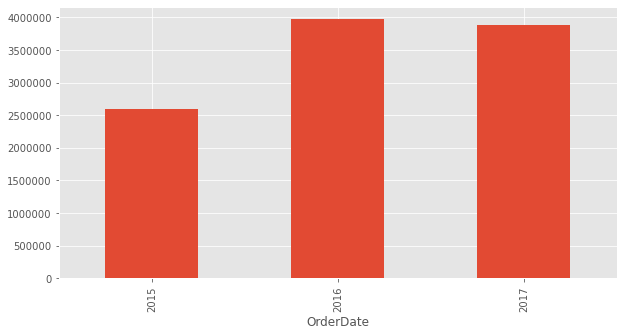

In [9]:
fig, axes = plt.subplots(figsize = (10, 5))
axes = report.merged_sales.groupby(report.merged_sales['OrderDate'].dt.year)\
        .sum()['Revenue']\
        .plot(kind = 'bar',);
axes.ticklabel_format(style='plain', axis='y')

#### Revenu Visualization with Heatmap

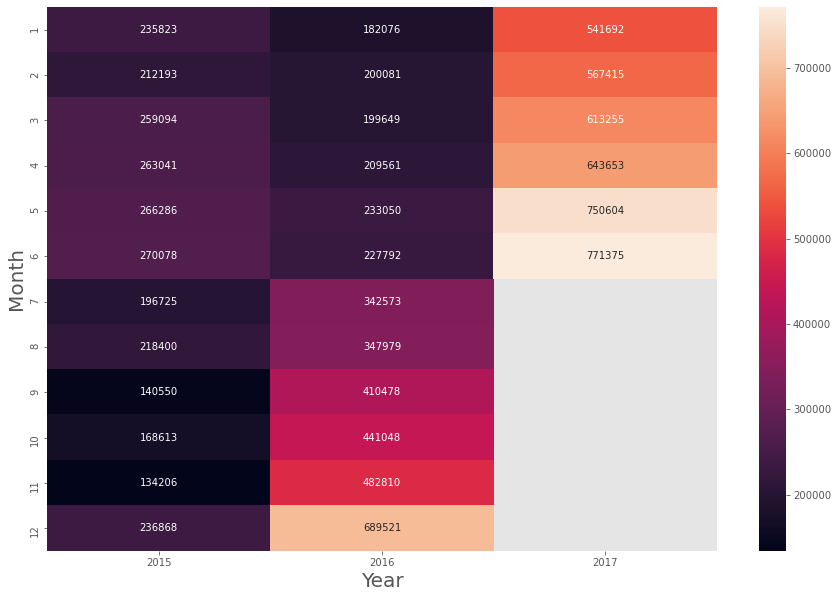

In [10]:
fig,axes = plt.subplots(figsize = (15, 10))

(sns.heatmap(data= pd.pivot_table(data= report.merged_sales,
                columns= 'Year',
               index = 'Month',
               values= 'Revenue',
                aggfunc='sum'), 
             ax= axes, annot = True, fmt = 'g')

);
axes.set_xlabel('Year',fontsize = 20);
axes.set_ylabel('Month',fontsize = 20);

In [11]:
(
    pd.pivot_table(data= report.merged_sales,
                columns= 'Year',
                index = 'Month',
                values= 'Revenue', 
                aggfunc='sum')
                .applymap(lambda number: format(number, '.0f'))
)

Year,2015,2016,2017
Month,,,
1,235823,182076,541692
2,212193,200081,567415
3,259094,199649,613255
4,263041,209561,643653
5,266286,233050,750604
6,270078,227792,771375
7,196725,342573,nan
8,218400,347979,nan
9,140550,410478,nan
